## Author: Kevin Okiah
## NLP :  Normalized Vocabulary Size Score and Text difficulty score.
## 02/07/2019

This notebook serves a primer to webscrapping using beautiful soup, selenium , lxml and urllib. In this notebook I scrape 103 graded readers books from Guternberg website http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf).

I develop and text cleaning function `TextCleaningToolkit.py` leveraging NLTK for the common text cleaning tasks like tokenization, lemming, stemming, etc. The tookit leverages NLTK library.

103 books are scrapped from Guternberg website. I take the following steps to clean and compare the books normalized vocabulary size and Text difficulty score

**Cleaning**
1. Strip GUTENBERG using function above.Book start is assumed to be the contents section
2. Break books into sentences/lines
3. Change senteces to lower case
4. Expland contractions for each sentence. Turning shortforms like Can't to Can not
5. Break lines into tokens
6. Remove punctuation marks
7. remove stopwords
8. Perform lemmatization
9. Store the cleaned book tones in a books dictionary for analysis.

The books are then compared in terms of Normalized_Vocab_Score

In [1]:
import numpy as np
import pandas as pd
import selenium
from lxml import html
import urllib3
from bs4 import BeautifulSoup
import lxml
import urllib 
import nltk
import string
from urllib import request
from string import punctuation

from TextCleaningToolkit import * 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

http = urllib3.PoolManager()

def get_url_Bs(url):
    tree = BeautifulSoup(url)
    return tree

def get_url_Sel(url):
    tree = html.document_fromstring(url)
    return tree

/home/kevimwe/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kevimwe/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
myurl = http.request('GET', "http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)").data#http.request('GET', "https://www.brightermonday.co.ke/search/jobs-in-nairobi/").data#http.request('GET', "http://www.jobwebkenya.com").data #desired url

tree = get_url_Sel(myurl)

In [3]:
links = tree.xpath('//a/@href')

In [4]:
def Book_Titles():
    '''
    Function to scrap book titles
    '''
    categories= tree.xpath('//*[(@id = "mw-content-text")]//*[(((count(preceding-sibling::*)+ 1) = 1) and parent::*)]')
    temp =[]
    temp2 =[]
    for i in categories:
        temp = temp+ i.cssselect('a')
    for j in temp:
            #print(len([j.text_content().split()]))
            t =j.text_content()
            temp2 = temp2+ [t.replace('\n','')]
    temp3 =pd.unique(temp2)
    book_titles = [x for x in temp3 if x]
    book_titles =book_titles[13:]
    return(book_titles)

book_titles = Book_Titles()
book_titles.insert(53, 'Dutch')

In [5]:
len(book_titles)

104

In [6]:
#pull all hyperlinks
def Books_Urls():
    '''
    Function to pull books urls. Some books numbers listed below have unique 
    url setup as such reconstructing their addess had to be persomed as in the code below
    '''
    
    SpecialUrls = [23424, 13853, 22795, 18274, 21973, 15950, 24222, 21783,2441, 17160, 22917, 23395]
    
    Bookslinks = tree.xpath('//a/@href')
    Books_urls= {} #declare urls Dictonary 
    Books2_urls= {} #declare urls Dictonary 
    n =0
    for i in Bookslinks :
        T = str.split(i, '/')

        if "www.gutenberg.org" in T and 'http:' not in T: 
            #print(SpecialUrls)
            if(int(T[4]) in SpecialUrls):
                #Format 1: http://www.gutenberg.org/files/23424/23424-0.txt
                Books2_urls.update({n:"http://" + T[2]+"/files/"+T[4]+"/"+T[4]+"-0.txt" })
            else:
                #Format 2:  http://www.gutenberg.org/cache/epub/7841/pg7841.txt 
                Books2_urls.update({n:"http://" + T[2]+"/cache/epub/"+T[4]+"/pg"+T[4]+".txt" })
                #Format 3: http://www.gutenberg.org/files/23424/23424-0.txt

            n =n+1
    return(Books2_urls)
booksUrls = Books_Urls()

In [7]:
len(booksUrls)

104

In [8]:
book_titles

['A Primary Reader: Old-time Stories, Fairy Tales and Myths Retold by Children',
 'The Bird-Woman of the Lewis and Clark Expedition',
 "Dr. Scudder's Tales for Little Readers, About the Heathen.",
 'The Louisa Alcott Reader: a Supplementary Reader for the Fourth Year of School',
 'Boy Blue and his friends, School ed.',
 'The Book of Nature Myths',
 "The Flag of My Country. Shikéyah Bidah Na'at'a'í;Navajo New World Readers 2",
 "Chambers's Elementary Science Readers, Book I",
 'The Little Lame Prince;Rewritten for Young Readers by Margaret Waters',
 "Harry's Ladder to Learning",
 'Little Present',
 'The Beacon Second Reader',
 "The Child's World Third Reader",
 'De La Salle Fifth Reader',
 'The Elson Readers, Book 5',
 'The Literary World Seventh Reader',
 "McGuffey's First Eclectic Reader, Revised Edition",
 "McGuffey's Second Eclectic Reader",
 "McGuffey's Third Eclectic Reader",
 "McGuffey's Fourth Eclectic Reader",
 "McGuffey's Fifth Eclectic Reader",
 "McGuffey's Sixth Eclectic Rea

In [9]:
def Book_CategoryMapper():
    '''
    Function tagging unique book categories. and mapping them to book urls
    '''
    
    titles_catagories = tree.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "mw-headline", " " ))]')
    tempx =[]
    BooksMapped = pd.DataFrame()
    for j in titles_catagories:
            tempx = tempx + [j.text_content()]
    Category_list =[]
    for i in tempx:
        if i =='Misc.':
            for n in range(11):
                Category_list = Category_list+ ['Misc.']
        if i =='Graded Readers':
            for n in range(20):
                Category_list = Category_list+ ['Graded Readers']
        if i =='Poetry Readers':
            for n in range(4):
                Category_list = Category_list+ ['Poetry Readers']
        if i =='Readers for English Speakers Learning Other Languages':
            for n in range(4):
                Category_list = Category_list+ ['Readers for English Speakers Learning Other Languages']
        if i =='Non-English Readers':
            for n in range(2):
                Category_list = Category_list+ ['Non-English Readers']
        if i =='About Readers':
            for n in range(1):
                Category_list = Category_list+ ['About Readers']
        if i =='Science and Nature':
            for n in range(29):
                Category_list = Category_list+ ['Science and Nature']
        if i =='History':
            for n in range(4):
                Category_list = Category_list+ ['History']
        if i =='Geography':
            for n in range(6):
                Category_list = Category_list+ ['Geography']
        if i =='Uncategorized':
            for n in range(23):
                Category_list = Category_list+ ['Uncategorized']
    BooksMapped["BookTitle"] =book_titles
    BooksMapped["Category"] = Category_list
    BooksMapped["url"] =booksUrls.values()
    return(BooksMapped)

In [10]:
BooksMapper =Book_CategoryMapper()

In [11]:
BooksMapper

,BookTitle,Category,url
0,"A Primary Reader: Old-time Stories, Fairy Tale...",Misc.,http://www.gutenberg.org/cache/epub/7841/pg784...
1,The Bird-Woman of the Lewis and Clark Expedition,Misc.,http://www.gutenberg.org/cache/epub/5742/pg574...
2,"Dr. Scudder's Tales for Little Readers, About ...",Misc.,http://www.gutenberg.org/cache/epub/13539/pg13...
3,The Louisa Alcott Reader: a Supplementary Read...,Misc.,http://www.gutenberg.org/cache/epub/7425/pg742...
4,"Boy Blue and his friends, School ed.",Misc.,http://www.gutenberg.org/cache/epub/16046/pg16...
5,The Book of Nature Myths,Misc.,http://www.gutenberg.org/cache/epub/22420/pg22...
6,The Flag of My Country. Shikéyah Bidah Na'at'a...,Misc.,http://www.gutenberg.org/files/23424/23424-0.txt
7,"Chambers's Elementary Science Readers, Book I",Misc.,http://www.gutenberg.org/cache/epub/18217/pg18...
8,The Little Lame Prince;Rewritten for Young Rea...,Misc.,http://www.gutenberg.org/cache/epub/24053/pg24...
9,Harry's Ladder to Learning,Misc.,http://www.gutenberg.org/cache/epub/24644/pg24...


In [12]:
def bookstart(strT):
    '''
    Marker for beginning of books. There are ~20 unique ways the books starte
    '''
    possible_starts = ['CONTENTS.', 'CONTENTS', '~CONTENTS~', 
                       '[Illustration]', '[Illustration: ]', 
                       'ILLUSTRATIONS.', 'THE ALPHABET.',
                       'Lessons.', 'SELECTIONS IN PROSE AND POETRY.', 'CONTENTS (5)', "L'IMPRUDENCE.",
                      'POEMS TEACHERS ASK FOR', 'Contents.', 'HOW TO USE THE BOOK', 'STORIES FROM LIVY.', 
                       'TABLE DES MATIÈRES.', 'OUR COMMON INSECTS.', 'CHAPTER ONE', '[Contents of the Books]',
                      '[Illustration: Laplander Travelling.]','CHAPTER ONE.', 'Contents', 'Stories in This Book',
                      'INHOUD.','INTRODUCTION.', '_THE PLAN BOOK SERIES_', 'Stanford Achievement Test']
    
    return(strT.lstrip() in possible_starts)

def bookend(strT):
    '''
    Marker for end of book.
    '''
    possible_ends  = ['End of the Project Gutenberg EBook', "End of Project Gutenberg's"]
    
    return(strT.startswith(possible_ends[0]) or strT.startswith(possible_ends[1]))

### Data Cleaning Perfomed in the code blocks that follow include.
1. Strip GUTENBERG using function above.Book start is assumed to be the contents section
2. Break books into sentences/lines
3. Change senteces to lower case
4. Expland contractions for each sentence. Turning shortforms like Can't to Can not
5. Break lines into tokens
6. Remove punctuation marks
7. remove stopwords
8. Perform lemmatization
9. Store the cleaned book tones in a books dictionary for analysis.

In [13]:
def parseBook(key =0,url="http://www.gutenberg.org/files/2441/2441-0.txt"):
    '''
    Strip header and footer GUTENBERG  from a book
    '''
    CleanBook =""
    Title =""
    Author =""
    try:
        respose = request.urlopen(url)
        raw = respose.read().decode("utf-8")
        #table = str.maketrans('', '', string.punctuation)
        Temp = list(raw.splitlines()) #Split raw the test in raw and store in an array
        flag = 0 #flag to track when to read and close a book
        CleanBook = [] #array to hold the desired sentences
        CleanTokens = []
        Author =""
        Title =""
        Tokens =[]
        for i in Temp:
            if(bookstart(i)==True):
                flag =1
            if(bookend(i)==True):
                flag =2
            try:
                Title = book_titles[key]
            except IndexError as e:
                print(e.args)
            Author = "tbd"
            if(flag==1):
                if(len(i)>0):
                    CleanBook.append(i)

    except request.HTTPError as err:
        if err.code == 404:
            print(err.code, " Error!!!")
        else:
            raise
    except UnicodeDecodeError  as e:
        print("UnicodeDecodeError!!  ", e.reason)
        #raise
    return(CleanBook, Title, Author)



book, Title, Author = parseBook()

In [14]:
def CleanBookTokens(book, Title, Author):
    '''
    Function to clean and tokenize a book
    '''
    CleanBook = [] #array to hold the desired sentences
    CleanTokens = []
    Tokens =[]    
    for i in book:
        sentence = expand_contractions(i)#expand contractions
        Tokens = Tokens + Tokenizer_Tool(sentence.lower(),'word_tokenize')#tokenize sentences
    words = [word for word in Tokens if word.isalpha()]#Remove punctuations
    CleanTokens = remove_stopwords(words)#Remove stopwords
    CleanTokens =lemming(CleanTokens) #Lemmetization of the tokens to get root words
    return(Title, CleanTokens)
#CleanBookTokens(book, Title, Author)

In [15]:
#Main
CleanBooks = {}
for key, value in booksUrls.items():
    try:
        book, Title, Author = parseBook(key, value)
        print ("processing :", key, value )#, "Book Length: ", len(book))
        if book != '':
            booktitle, booktokens =CleanBookTokens(book, Title, Author)
            CleanBooks.update({booktitle:booktokens})
    except IndexError as e:
        print(e.args)
print("processing complete...")

processing : 0 http://www.gutenberg.org/cache/epub/7841/pg7841.txt
processing : 1 http://www.gutenberg.org/cache/epub/5742/pg5742.txt
processing : 2 http://www.gutenberg.org/cache/epub/13539/pg13539.txt
processing : 3 http://www.gutenberg.org/cache/epub/7425/pg7425.txt
processing : 4 http://www.gutenberg.org/cache/epub/16046/pg16046.txt
processing : 5 http://www.gutenberg.org/cache/epub/22420/pg22420.txt
processing : 6 http://www.gutenberg.org/files/23424/23424-0.txt
processing : 7 http://www.gutenberg.org/cache/epub/18217/pg18217.txt
processing : 8 http://www.gutenberg.org/cache/epub/24053/pg24053.txt
processing : 9 http://www.gutenberg.org/cache/epub/24644/pg24644.txt
processing : 10 http://www.gutenberg.org/cache/epub/24703/pg24703.txt
processing : 11 http://www.gutenberg.org/cache/epub/15659/pg15659.txt
processing : 12 http://www.gutenberg.org/cache/epub/15170/pg15170.txt
processing : 13 http://www.gutenberg.org/cache/epub/10811/pg10811.txt
processing : 14 http://www.gutenberg.org/

### 1. In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. (Various methods will be discussed in the live session.)

Resusing same code from homework 2 but applying it on the 103 books to get the normalised score per book.

In [32]:
import inspect
code, line_no = inspect.getsourcelines(Normalized_Vocab_Score)
print(''.join(code))

def Normalized_Vocab_Score(Texts, BooksMapper):
    '''
    This function normalizes the vocabulary size score for texts passed in a list
    Normalizations:
        1. v_raw_score = Vocab_Size_Text(i)/ Max(Vocab_Size_Texts)
        2. v_sqrt_score = sqrt(v_raw_score)
        3. v_minmax_score = MinMaxScaler(v_raw_score)
        4. v_final_score = avg(v_sqrt_score, v_minmax_score)
    '''
    Summary = pd.DataFrame()
    VocabSize = []
    v_raw_score =[]
    v_sqrt_score =[]
    category =[]
    
    #Vocab Size
    f = lambda x:Vocab_size(x)
    VocabSize = [f(x) for x in list(Texts.values())]
    books = list(Texts.keys())
    
    #lexical diversity score
    f_lx = lambda x:lexical_diversity(x)
    Lexical_diversity = [f_lx(x) for x in list(Texts.values())]
    
    #v_raw Score
    f_raw = lambda x:x/max(VocabSize)
    v_raw_score = [f_raw(x) for x in VocabSize]
    
    for i in books:
        category = category + list(BooksMapper[BooksMapper.BookTitle==i].Category)
    
    
 

In [33]:
NV_Vocab =Normalized_Vocab_Score(CleanBooks, BooksMapper)
NV_Vocab.head()

,Category,Lexical_diversity,Title,V_Raw_Score,V_Sqrt_Score,V_minmax_Score,VocabSize,V_Normalized_FinalScore
0,Misc.,0.141611,"A Primary Reader: Old-time Stories, Fairy Tale...",0.055425,0.235426,0.052281,568,0.143854
1,Misc.,0.173097,The Bird-Woman of the Lewis and Clark Expedition,0.082748,0.287659,0.079695,848,0.183677
2,Misc.,0.181315,"Dr. Scudder's Tales for Little Readers, About ...",0.297326,0.545276,0.294987,3047,0.420132
3,Misc.,0.147972,The Louisa Alcott Reader: a Supplementary Read...,0.281909,0.530951,0.279518,2889,0.405235
4,Misc.,0.149008,"Boy Blue and his friends, School ed.",0.081382,0.285275,0.078324,834,0.181799


In [34]:
#Visualize, Vocab Size, Lexical_diversity Score, V_normalized by Category

Text(0.5,1,'V_Normalized_FinalScore by Category')

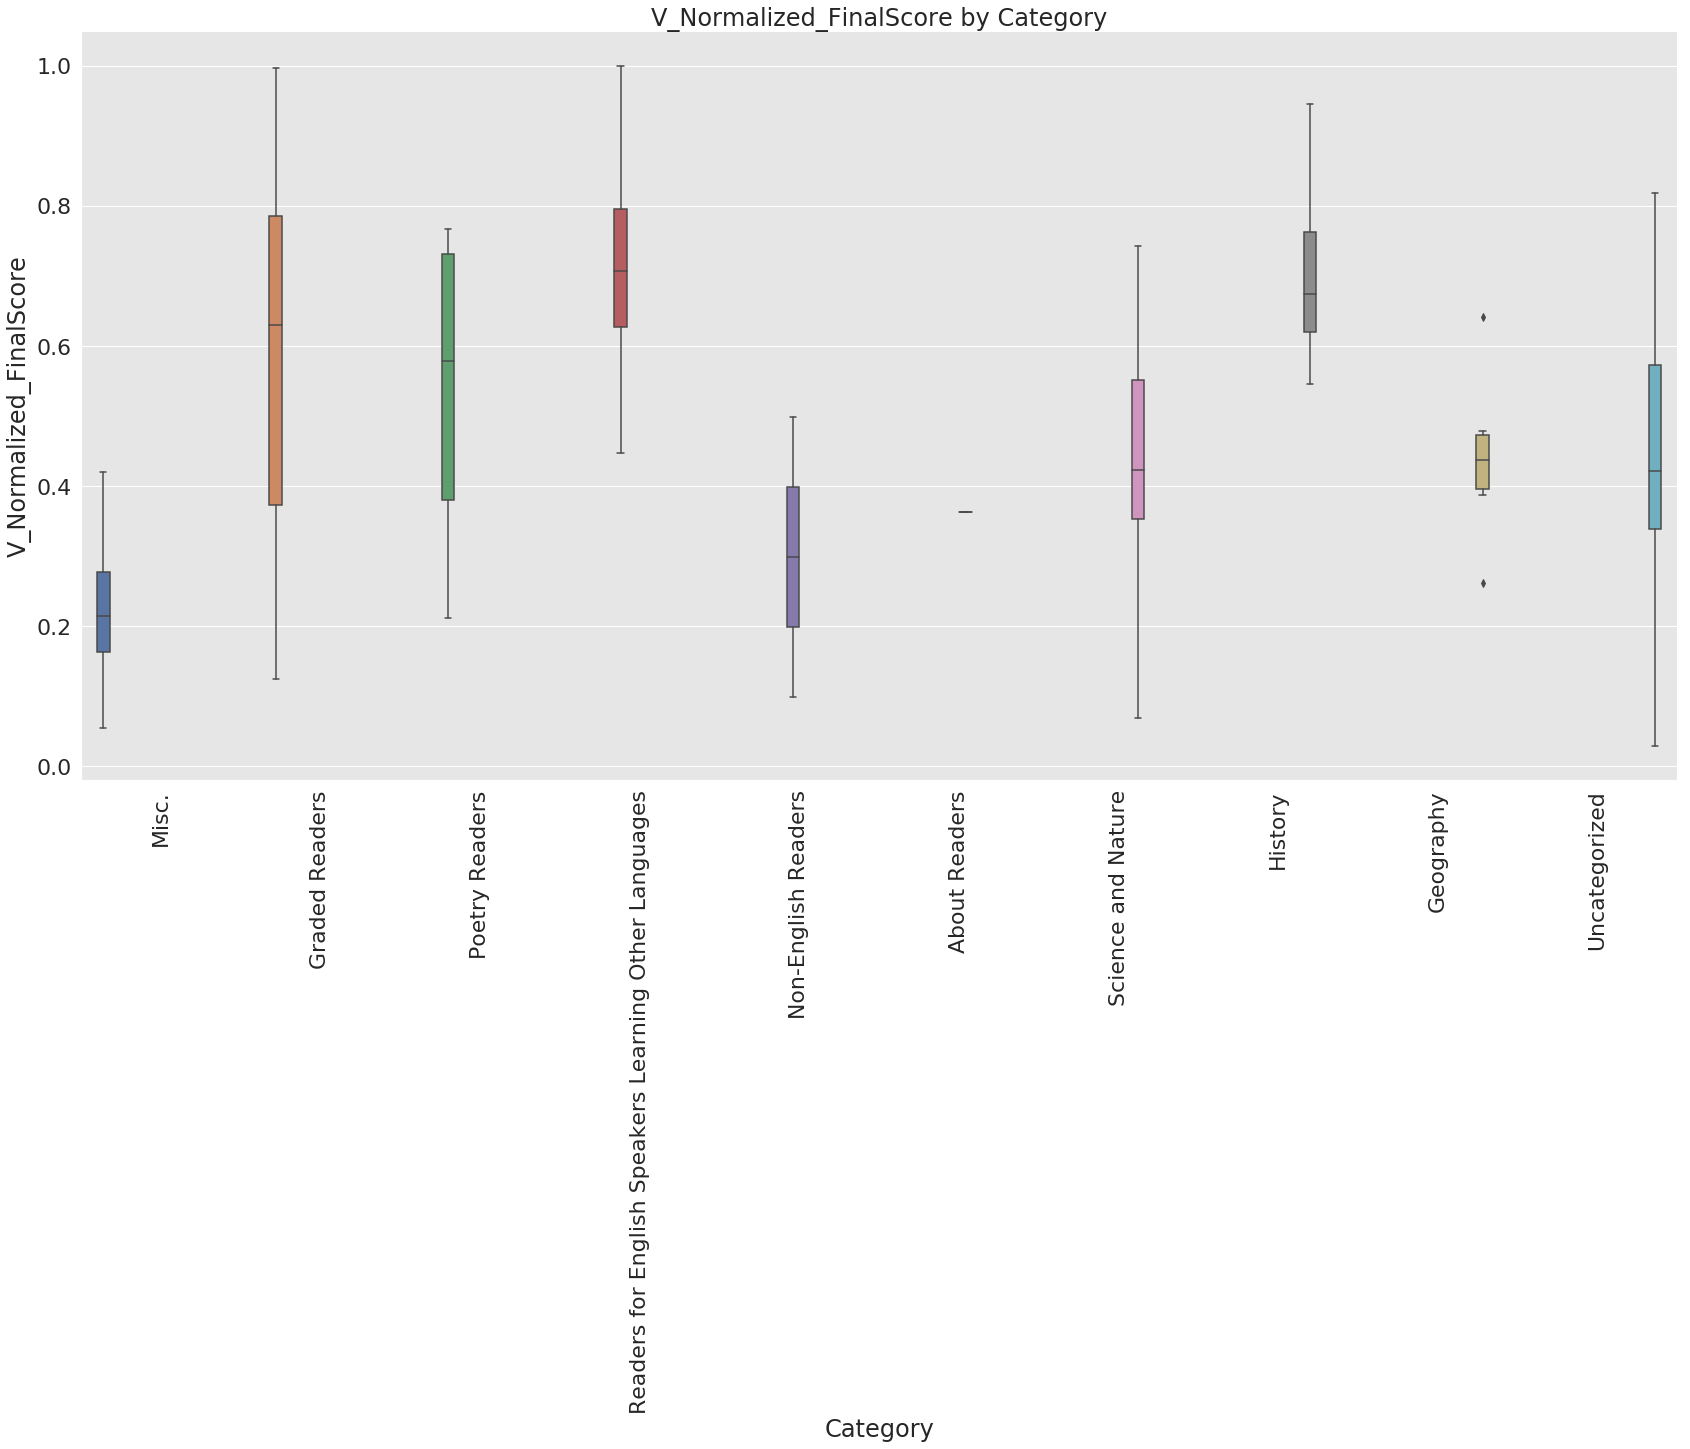

In [35]:
sns.set(font_scale=2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
g = sns.catplot(x='Category', y="V_Normalized_FinalScore",
               hue='Category',
               data=NV_Vocab, kind="box",
               height=12, aspect=2)
g.set_xticklabels(rotation=90)
plt.title("V_Normalized_FinalScore by Category")

Graded Readers, Readers for English Speakers Learning other Languages and History catagories have the highest Normalised Vocal score.

Misc Category has the lowest average normalised Vocabulary score.

Text(0.5,1,'Lexical_diversity by Category')

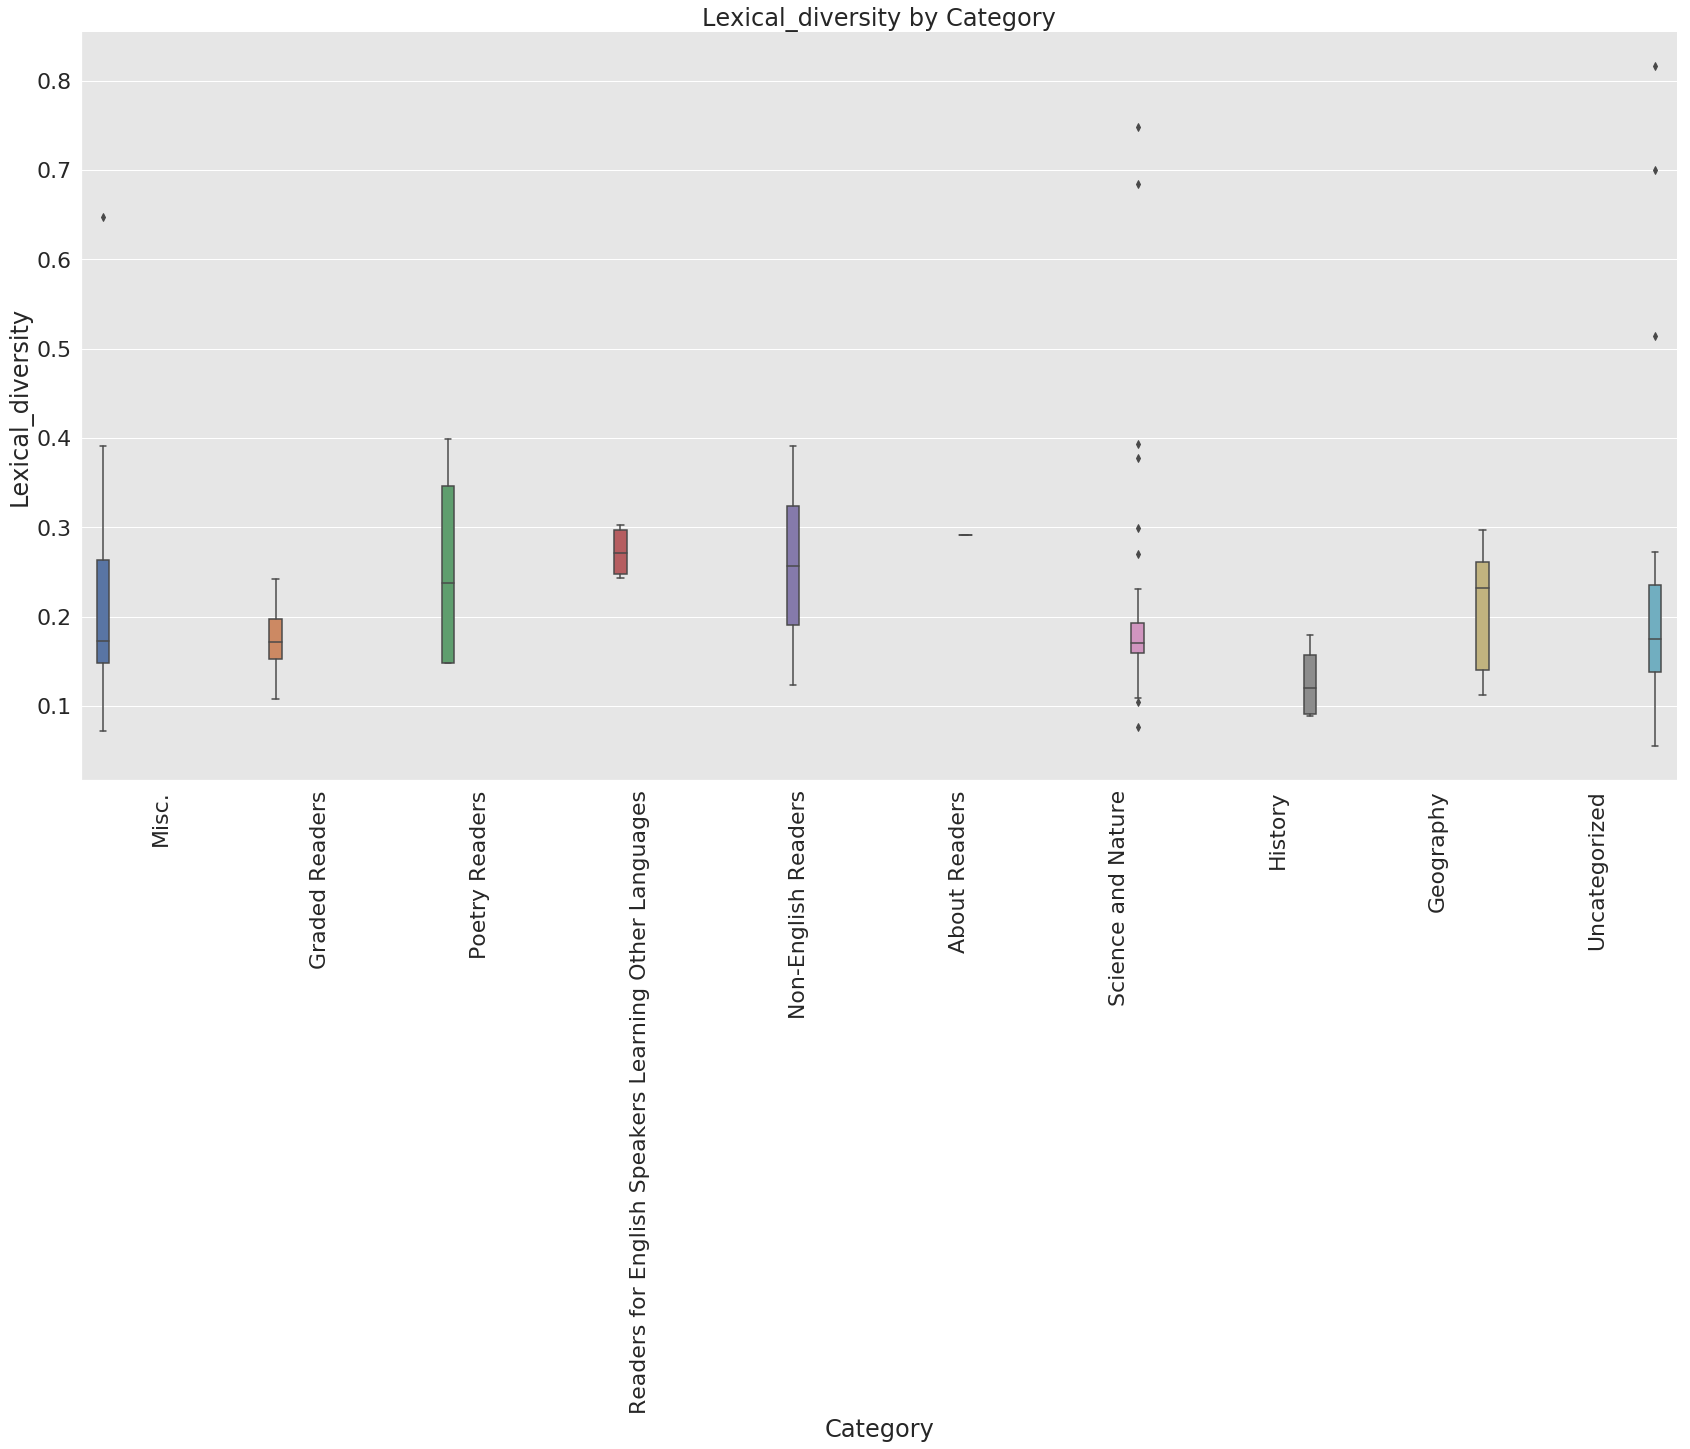

In [36]:
sns.set(font_scale=2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
g = sns.catplot(x='Category', y="Lexical_diversity",
               hue='Category',
               data=NV_Vocab, kind="box",
               height=12, aspect=2)
g.set_xticklabels(rotation=90)
plt.title("Lexical_diversity by Category")

Most books catagories have average lexical diversity scores less than 0.3.

Science & Nature and Uncategorized   categorises have a number of outlier lexical diversity scores.

### Below is the list of books used in previous Homeworks we will eveluate them in comparion with the pool of 103 books in terms in Normalised Score, Long word Score and Text difficulty score similar to how the evaluation was done in homework 2

In [37]:
#books used in homework 2
TargetedBooks = {"2nd":"http://www.gutenberg.org/cache/epub/15659/pg15659.txt", #2nd grader book
                 "4th":"http://www.gutenberg.org/cache/epub/18702/pg18702.txt", #4th grader book
                 "HS":"http://www.gutenberg.org/cache/epub/19923/pg19923.txt"}  #High School grader 
thelist =BooksMapper[BooksMapper.url.isin(list(TargetedBooks.values()))]
thelist

,BookTitle,Category,url
11,The Beacon Second Reader,Graded Readers,http://www.gutenberg.org/cache/epub/15659/pg15...
25,The Ontario Readers: Fourth Book,Graded Readers,http://www.gutenberg.org/cache/epub/18702/pg18...
26,"The Ontario Readers: The High School Reader, 1886",Graded Readers,http://www.gutenberg.org/cache/epub/19923/pg19...


In [38]:
NV_Vocab[NV_Vocab.Title.isin(list(thelist.BookTitle))]

,Category,Lexical_diversity,Title,V_Raw_Score,V_Sqrt_Score,V_minmax_Score,VocabSize,V_Normalized_FinalScore
11,Graded Readers,0.242430,The Beacon Second Reader,0.264832,0.514618,0.262385,2714,0.388502
25,Graded Readers,0.184367,The Ontario Readers: Fourth Book,0.714871,0.845501,0.713922,7326,0.779711
26,Graded Readers,0.159593,"The Ontario Readers: The High School Reader, 1886",0.949258,0.974299,0.949089,9728,0.961694


Normalized Vocab size final score (V_Normalized_FinalScore) as an average of two scores *V_Sqrt_Score* and *V_minmax_Score* for the Vocabulary size (VocabSize). 
 * **V_Sqrt_Score** is  the square root of the **V_Raw_Score** derived by scaling Vocabulary size(VocabSize) for a given book to that of the book with the largest  Long Word vocabulary size in the list 103 books
 * **V_minmax_Score** on the other hand scales a Vocab size to a range between 0 and 1 with 0 being the min vocab size and 1 being the max  vocab size. Please code above for for MinMaxScaler implementation.

###   2.	After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.

In [39]:
NV_L_Vocab =Normalized_Long_Word_Vocab_Score(CleanBooks, BooksMapper, 14)
NV_L_Vocab.head()

,Category,Lexical_diversity,LongWordVocabSize,Title,V_Raw_Score,V_Sqrt_Score,V_minmax_Score,V_Normalized_LW_FinalScore
0,Misc.,0.141611,0,"A Primary Reader: Old-time Stories, Fairy Tale...",0.000000,0.000000,0.000000,0.000000
1,Misc.,0.173097,0,The Bird-Woman of the Lewis and Clark Expedition,0.000000,0.000000,0.000000,0.000000
2,Misc.,0.181315,1,"Dr. Scudder's Tales for Little Readers, About ...",0.015152,0.123091,0.015152,0.069122
3,Misc.,0.147972,1,The Louisa Alcott Reader: a Supplementary Read...,0.015152,0.123091,0.015152,0.069122
4,Misc.,0.149008,0,"Boy Blue and his friends, School ed.",0.000000,0.000000,0.000000,0.000000


Text(0.5,1,'V_Normalized_LW_FinalScore by Category')

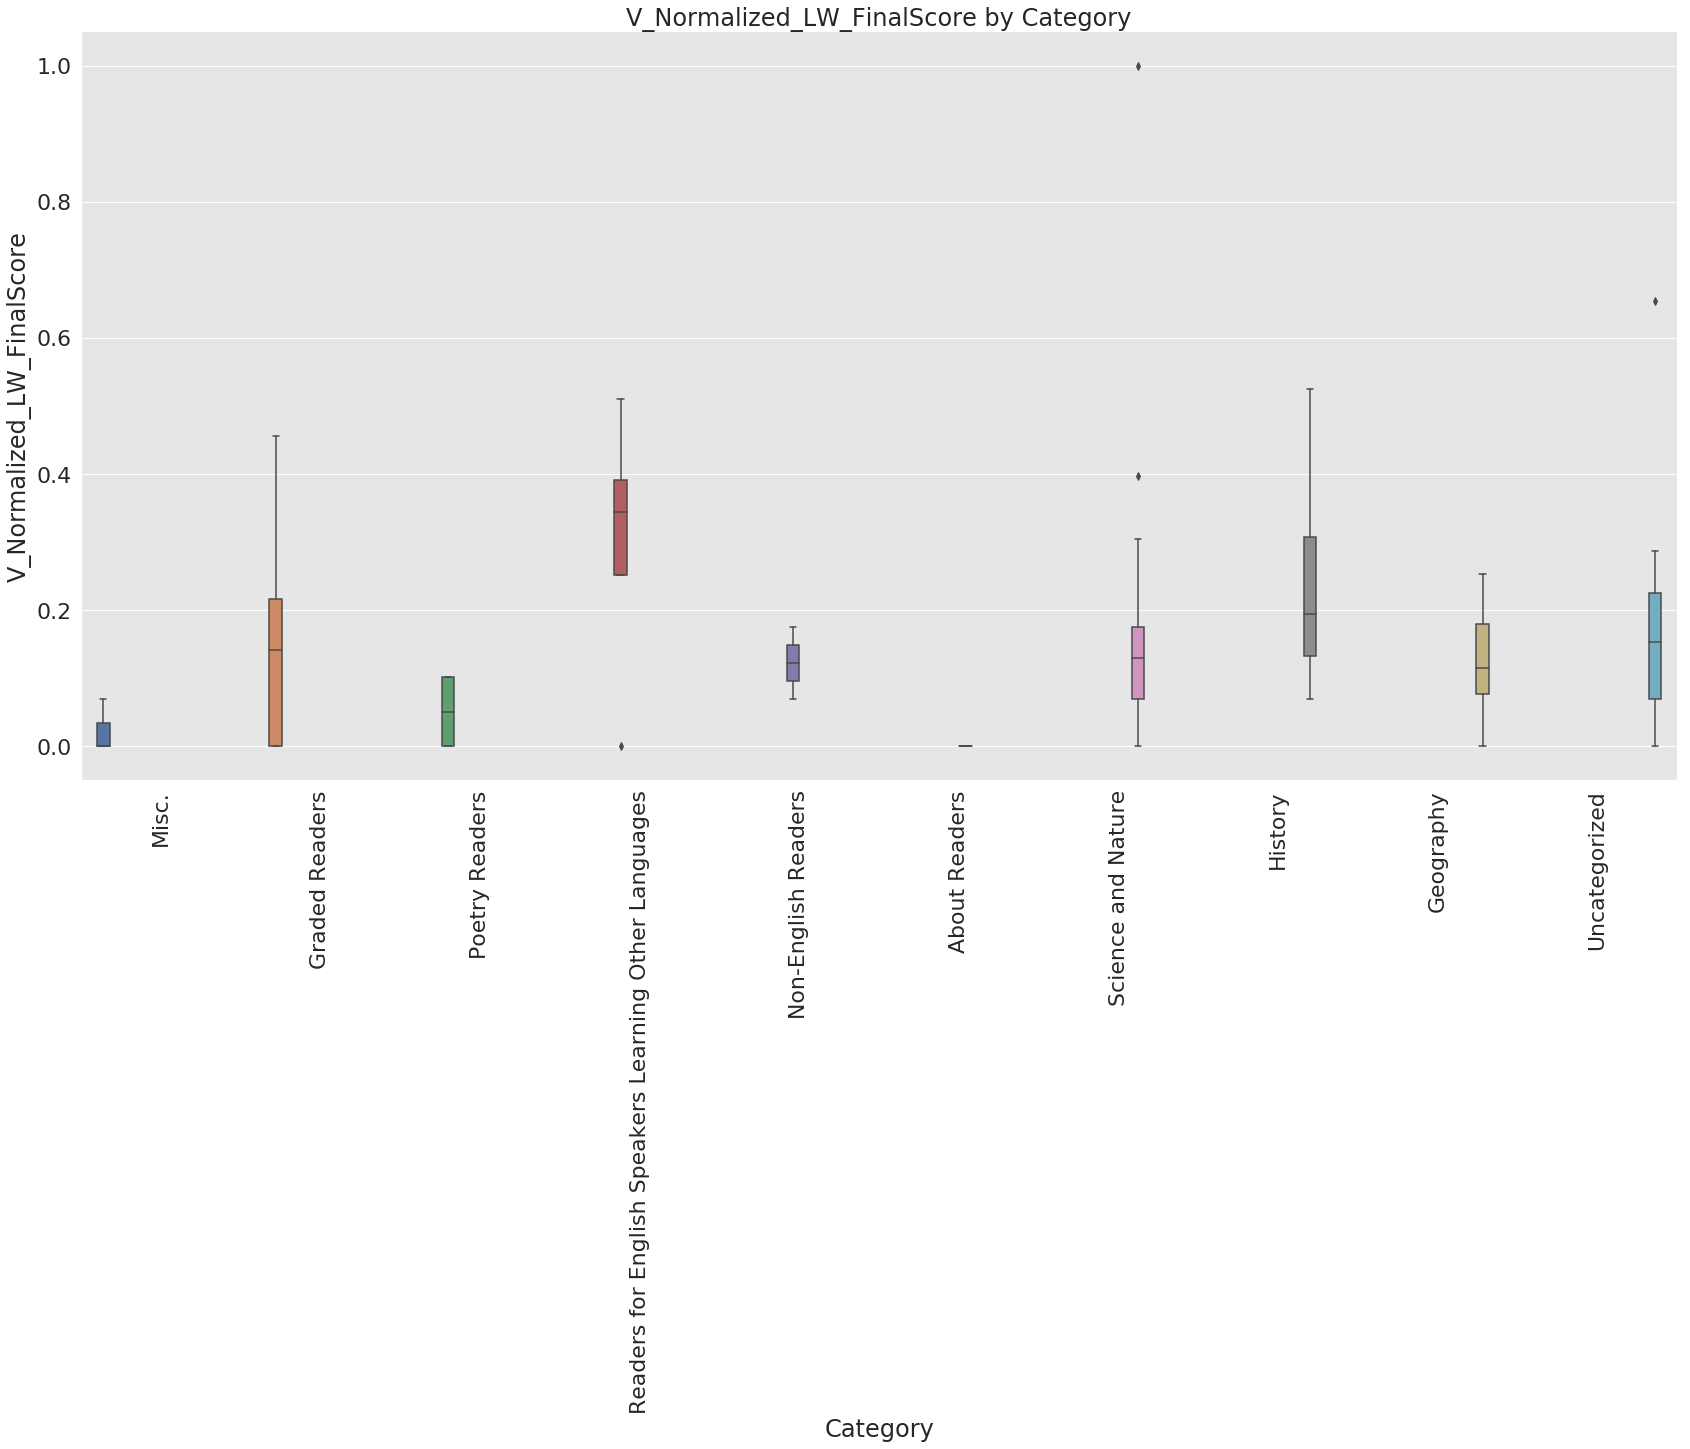

In [40]:
sns.set(font_scale=2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
g = sns.catplot(x='Category', y="V_Normalized_LW_FinalScore",
               hue='Category',
               data=NV_L_Vocab, kind="box",
               height=12, aspect=2)
g.set_xticklabels(rotation=90)
plt.title("V_Normalized_LW_FinalScore by Category")

Average Long Word normalized Vocab score is below 0.2 for all categories

Graded Readers, Readers for English Speakers Learning other Languages and History catagories have the highest long word Normalised Vocal score.

Compared to normalized Vocab score, most books catagories have a lower long word normalised score which is expected.

In [41]:
import inspect
code, line_no = inspect.getsourcelines(Normalized_Long_Word_Vocab_Score)
print(''.join(code))

def Normalized_Long_Word_Vocab_Score(Texts,BooksMapper, minChar =14):
    '''
    This function normalizes the Long Word vocabulary size score for texts passed in a list
    Normalizations:
        1. v_raw_score = Vocab_Size_Text(i)/ Max(Vocab_Size_Texts)
        2. v_sqrt_score = sqrt(v_raw_score)
        3. v_minmax_score = MinMaxScaler(v_raw_score)
        4. v_final_score = avg(v_sqrt_score, v_minmax_score)
    '''
    Summary = pd.DataFrame()
    VocabSize = []
    v_raw_score =[]
    v_sqrt_score =[]
    category = []
    
    #Vocab Size
    f = lambda x:Long_Word_Vocab_Size(x, minChar)
    VocabSize = [f(x) for x in list(Texts.values())]
    books = list(Texts.keys())
    
    for i in books:
        category = category + list(BooksMapper[BooksMapper.BookTitle==i].Category)
        
    
    #lexical diversity score
    f_lx = lambda x:lexical_diversity(x)
    Lexical_diversity = [f_lx(x) for x in list(Texts.values())]
    
    #v_raw Score
    f_raw = lambda x:x/max(VocabSize

In [42]:
NV_L_Vocab[NV_L_Vocab.Title.isin(list(thelist.BookTitle))]

,Category,Lexical_diversity,LongWordVocabSize,Title,V_Raw_Score,V_Sqrt_Score,V_minmax_Score,V_Normalized_LW_FinalScore
11,Graded Readers,0.242430,1,The Beacon Second Reader,0.015152,0.123091,0.015152,0.069122
25,Graded Readers,0.184367,7,The Ontario Readers: Fourth Book,0.106061,0.325669,0.106061,0.215865
26,Graded Readers,0.159593,22,"The Ontario Readers: The High School Reader, 1886",0.333333,0.577350,0.333333,0.455342


I derive my Normalized Vocab size final score (V_Normalized_FinalScore) as an average of two scores *V_Sqrt_Score* and *V_minmax_Score* for the Vocabulary size (VocabSize). 
 * **V_Sqrt_Score** is  the square root of the **V_Raw_Score** derived by scaling Vocabulary size(VocabSize) for a given book to that of the book with the largest  Long Word vocabulary size in the list of 103 books. 
 * **V_minmax_Score** on the other hand scales a Vocab size to a range between 0 and 1 with 0 being the min vocab size and 1 being the max  vocab size.  MinMaxScaler implementation is the same as that from homework 2 just applied on the 103 books. See code in appendix

### 3.	Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts you used in homework 1.

In [43]:
Summary =Text_Difficulty_Score(CleanBooks, BooksMapper)
Summary.head()

,Title,Category,VocabSize,LongWordVocabSize,Lexical_diversity,V_Normalized_FinalScore,V_Normalized_LW_FinalScore,Text_Difficulty_Score
0,"A Primary Reader: Old-time Stories, Fairy Tale...",Misc.,568,0,0.141611,0.143854,0.000000,9.515474
1,The Bird-Woman of the Lewis and Clark Expedition,Misc.,848,0,0.173097,0.183677,0.000000,11.892448
2,"Dr. Scudder's Tales for Little Readers, About ...",Misc.,3047,1,0.181315,0.420132,0.069122,22.352280
3,The Louisa Alcott Reader: a Supplementary Read...,Misc.,2889,1,0.147972,0.405235,0.069122,20.744258
4,"Boy Blue and his friends, School ed.",Misc.,834,0,0.149008,0.181799,0.000000,11.026925


In [44]:
Summary[Summary.Title.isin(list(thelist.BookTitle))]

,Title,Category,VocabSize,LongWordVocabSize,Lexical_diversity,V_Normalized_FinalScore,V_Normalized_LW_FinalScore,Text_Difficulty_Score
11,The Beacon Second Reader,Graded Readers,2714,1,0.242430,0.388502,0.069122,23.335096
25,The Ontario Readers: Fourth Book,Graded Readers,7326,7,0.184367,0.779711,0.215865,39.331439
26,"The Ontario Readers: The High School Reader, 1886",Graded Readers,9728,22,0.159593,0.961694,0.455342,52.554305


While there was a progressive decrease in the lexical diversity score from 2nd grade to 4th grade to high school, The text difficulty score inceases as we progress from lower grades to higher grades. High school students are expected to comprehend texts with higher text difficulty compared to those at lower grades. This trend holds from what we saw in homework 2 though scores are slightly lower than from the last homework when we had scores calculated from 3 books.

## Extra Visualization

Text(0.5,1,'VocabSize vs Text Difficulty Score')

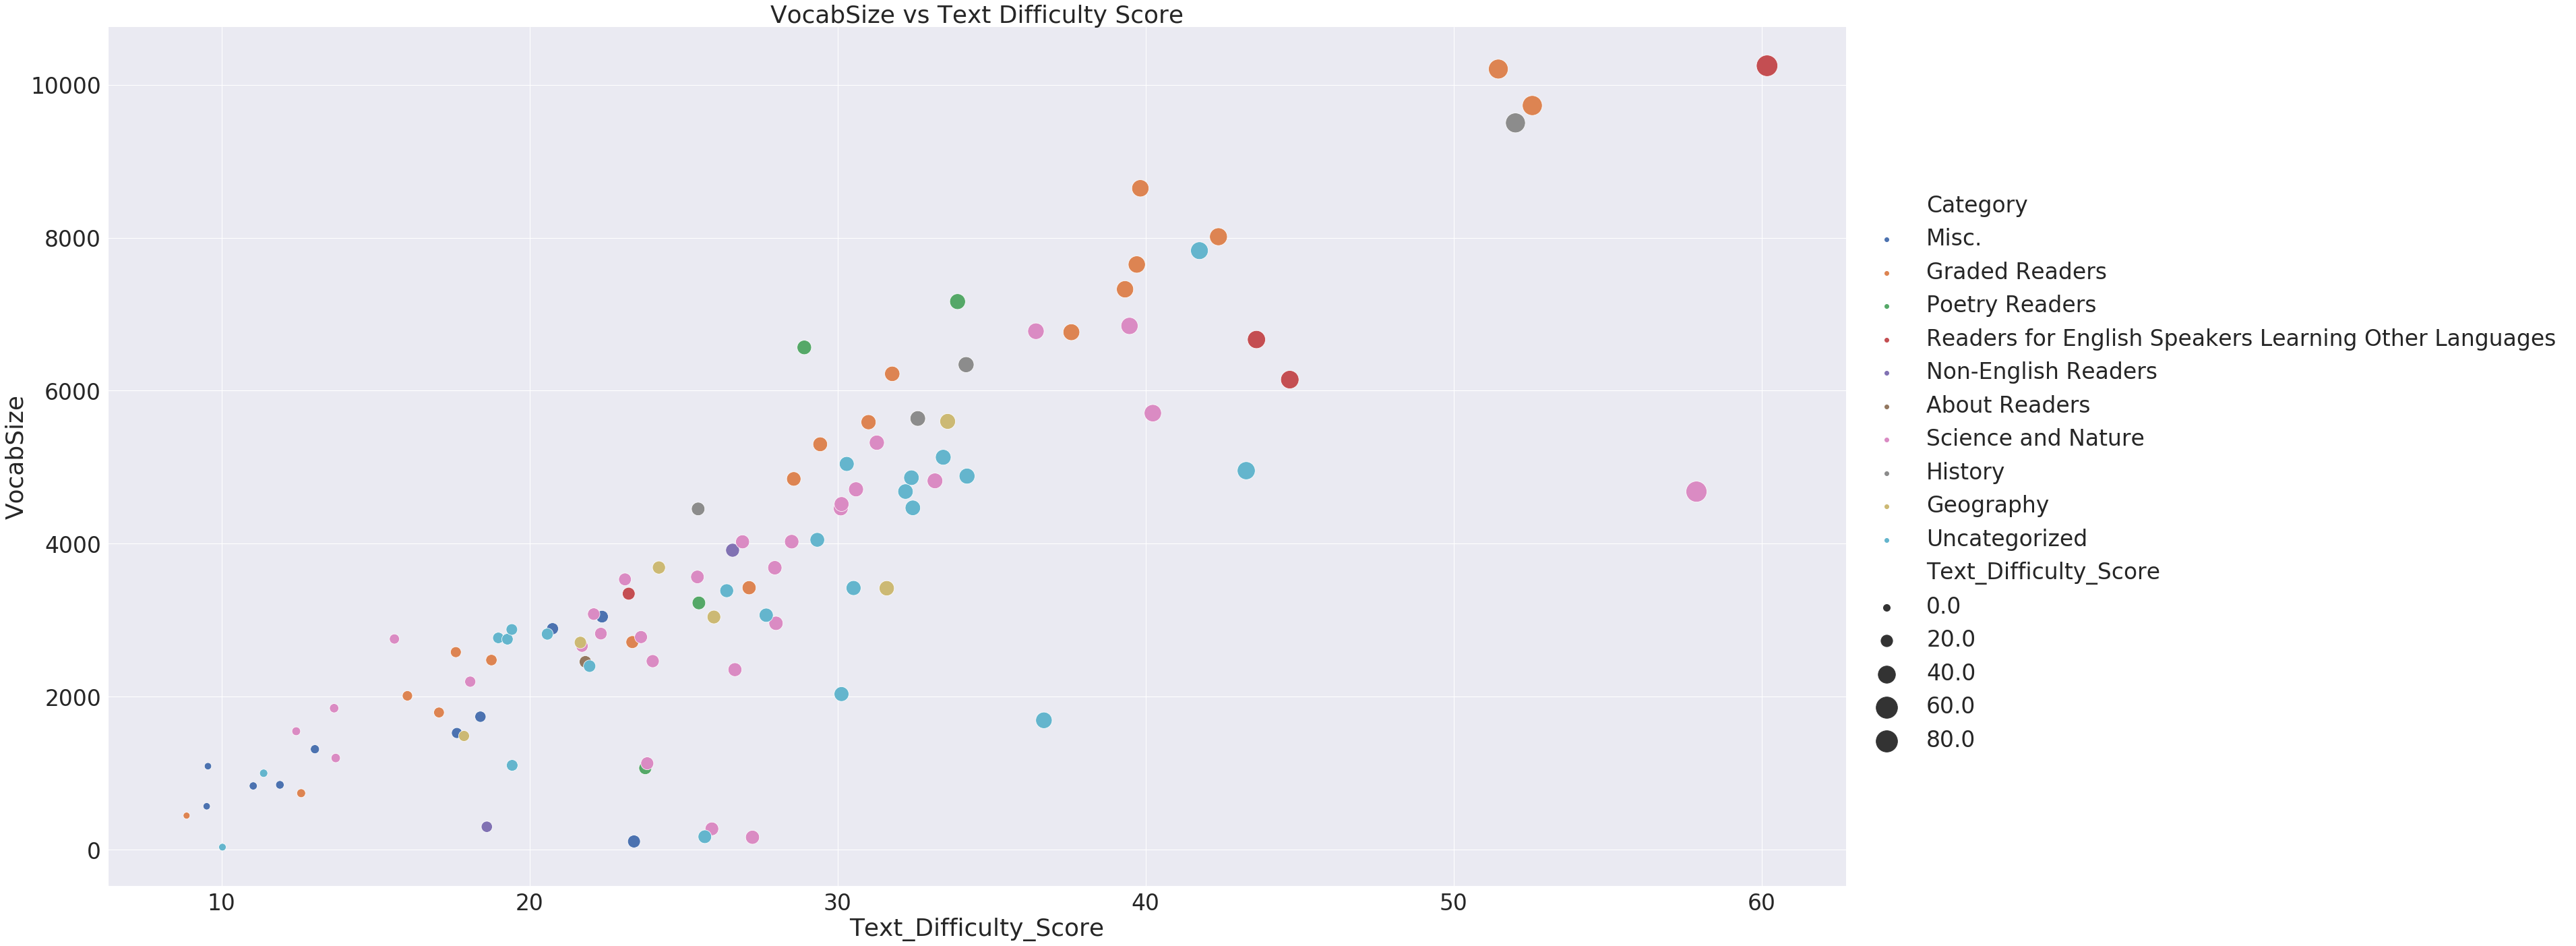

In [45]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=3)
g = sns.relplot(x="Text_Difficulty_Score", y="VocabSize", data=Summary,height=20, aspect=2,
                hue="Category", size="Text_Difficulty_Score",sizes=(100, 1000),marker="o")
plt.title('VocabSize vs Text Difficulty Score')


There is strong positive correlation between VocabSize and Text_Difficulty score

### Appendix

In [46]:
%load_ext version_information
%version_information pandas, numpy, nltk, re, contractions

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.2.0
OS Linux 4.15.0 46 generic x86_64 with debian buster sid
pandas 0.20.3
numpy 1.15.0
nltk 3.2.5
re 2.2.1
contractions 0.0.17
Sun Mar 31 16:09:04 2019 CDT

 Below is the lexicalDiversityToolkit Library

In [50]:

import inspect
import TextCleaningToolkit
code, line_no = inspect.getsourcelines(TextCleaningToolkit)
print(''.join(code))

#!/usr/bin/python
# -*- coding: utf-8 -*-

'''
Author: Kevin Okiah
Changes:
    - 1/26/2019: Default code with basic functions for for lexical analysis
    -
'''

from __future__ import division
import future

#Library Imports
import nltk
try:
    import request
except:
    from urllib import request
import urllib

from nltk import word_tokenize
import re
import string
from string import punctuation
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer 
from nltk.stem import RegexpStemmer #user defined rules
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import contractions
import pandas as pd
import numpy as np




def lexical_diversity(text):
    '''
    This functon calculated lexical_diversity score for a given text
    '''
    return len(set(text))/len(text) 
    
def percentage(count, total):
    '''
    Functions returns a percentage for a given count
    '''
    return 100 * count / total